# VizDoom Basic

All credits to Nicholas Renotte\
Code reproduced only for learning purposes

---

# 1. Getting VizDoom

In [1]:
# Cloning repository
#!mkdir github
#!cd github & git clone https://github.com/mwydmuch/ViZDoom

A subdirectory or file github already exists.
fatal: destination path 'ViZDoom' already exists and is not an empty directory.


In [2]:
import random
import time
import numpy as np
import os

import matplotlib.pyplot as plt

from vizdoom import *

In [3]:
# Setup Game
game = DoomGame()
game.load_config('github/VizDoom/scenarios/basic.cfg')
game.init()

In [4]:
# Set of all actions
actions = np.identity(3, dtype=np.uint8)
print("Left, Right, Shoot")
actions

Left, Right, Shoot


array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

In [5]:
# Game with random actions
episodes = 3

for episode in range(episodes):
    game.new_episode()
    
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables
        reward = game.make_action(random.choice(actions), 4) # 4 = skipping 4 frames each iteration
        print("reward:", reward)
        time.sleep(0.02)
        
    print("Result:", game.get_total_reward())
    time.sleep(2)
    
game.close()

reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: 99.0
Result: 38.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0

# 2. Converting Game To Gym Environment

In [6]:
from gym import Env
from gym.spaces import Discrete, Box
import cv2

In [7]:
class VizDoomGym(Env):
    """ Doom game class """
    
    def __init__(self, render=False):
        """ Inicializing game """
        
        # Inherit from Env
        super().__init__()
        
        # Setup the game
        self.game = DoomGame()
        self.game.load_config('github/VizDoom/scenarios/basic.cfg')
        
        # Render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
            
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(80,160,1), dtype=np.uint8)
        self.action_space = Discrete(3)
    
    
    def step(self, action):
        """ Step in Environment """
        
        # Specify action and take step
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4)
        
        # Get other things
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.greyscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = ammo
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
            
        info = {"info": info}
        done = self.game.is_episode_finished()
            
        return state, reward, done, info
    
    
    def render():
        pass
    
    
    def reset(self):
        """ Reseting the Environment """
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.greyscale(state)
    
    
    def greyscale(self, observation):
        """ Applying greyscale, reshaping and removing HUD """
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state[:80,:]
    
    
    def close(self):
        """ Closing game """
        self.game.close()

# 3. View Game

In [8]:
# Opening the game
env = VizDoomGym(render=True)

In [11]:
# agent that tests if environment is setup correctly
from stable_baselines3.common import env_checker
env_checker.check_env(env)

In [12]:
# Action 2: shoot
env.step(2);

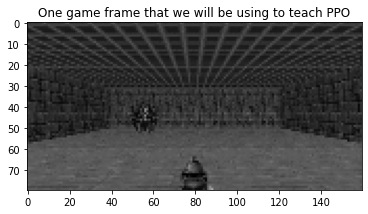

In [13]:
# Displaying evironment for learning 
state = env.reset()
plt.title("One game frame that we will be using to teach PPO")
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB));

In [14]:
env.close()

# 4. Setup Callback

In [15]:
from stable_baselines3.common.callbacks import BaseCallback

class TrainAndLoggingCallback(BaseCallback):
    """
    Callback class that save the model after n steps of iteration
    """
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
    
        return True

In [16]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [ ]:
callback = TrainAndLoggingCallback(check_freq = 10_000, save_path=CHECKPOINT_DIR)

# 4. Training the Model

In [17]:
# importing PPO algorithm
from stable_baselines3 import PPO

In [18]:
# Non rendered environment
env = VizDoomGym()

In [ ]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048)

In [ ]:
model.learn(total_timesteps=150_000, callback=callback)

### INFO

ep_len_mean = mean of frames that it takes to end episode\
ep_rew_mean = mean of episode rewards\
approx_kl = diffrence between current policy and previous policy\
clip_fraction = similar to approx_kl\
explained_variance = how our critic is correctly predicting the reward or future


#### to check results using tensorflow dashboard:
 "open cmd"\
 "go to folder"\
 activate\
 cd logs\
 cd PPO_3 "latest PPO"\
 tensorboard --logdir=.\
 "copy given link and paste into browser" (link looks like this http://localhost:6006/)

# 5. Testing The Model

In [19]:
# Importing eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
# Testing each model 100 times

env = VizDoomGym()

for i in range(10_000, 160_000, 10_000):
    # Reloading best model
    model = PPO.load(f'./train/train_basic/best_model_{i}')
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)
    print(i, "=", mean_reward)

env.close()

after best_model_40000 models covergerged to optimal solution

In [20]:
# Displaying how agent plays the game

model = PPO.load(f'./train/train_basic/best_model_60000')
env = VizDoomGym(render=1)

for episode in range(5):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.2)
        total_reward += reward
    
    print(f"Total reward for episode {episode+1} is {total_reward}")
    time.sleep(2)
    
env.close()

Total reward for episode 1 is 95.0
Total reward for episode 2 is 79.0
Total reward for episode 3 is 95.0
Total reward for episode 4 is 67.0
Total reward for episode 5 is 87.0
Total reward for episode 6 is 87.0
Total reward for episode 7 is 95.0
Total reward for episode 8 is 79.0
Total reward for episode 9 is 95.0
Total reward for episode 10 is 79.0
Total reward for episode 11 is 75.0
Total reward for episode 12 is 83.0
Total reward for episode 13 is 44.0
Total reward for episode 14 is 95.0
Total reward for episode 15 is 79.0
Total reward for episode 16 is 67.0
Total reward for episode 17 is 95.0
Total reward for episode 18 is 79.0
Total reward for episode 19 is 83.0
Total reward for episode 20 is 95.0
